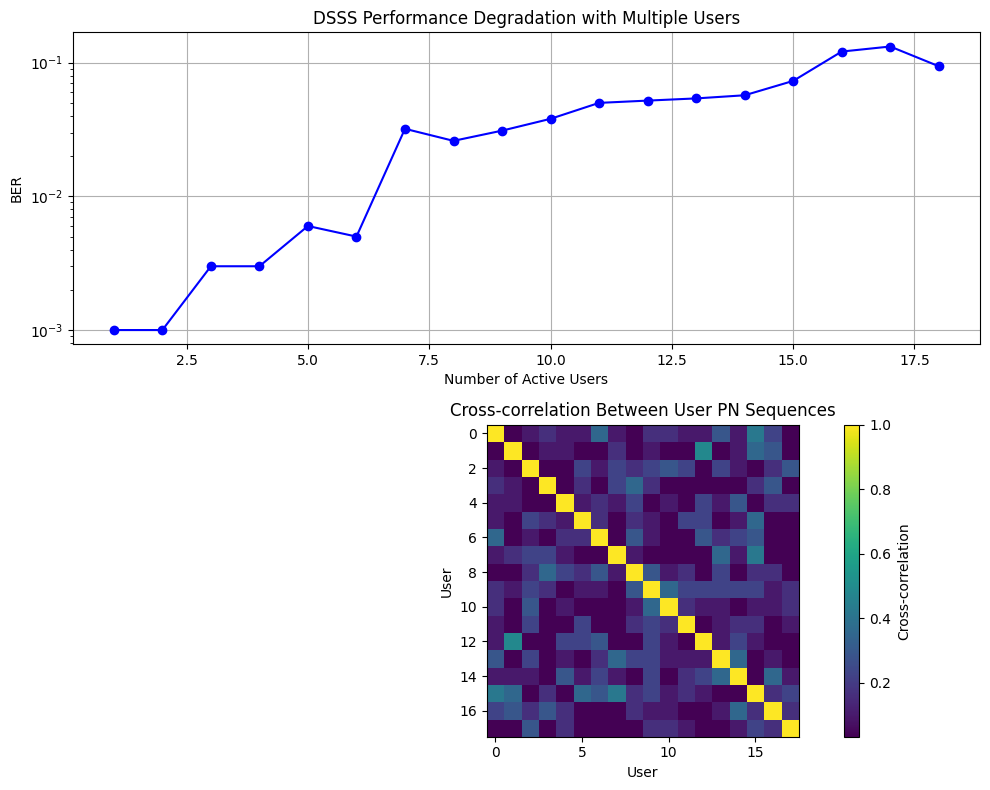

Average BER: 4.328e-02


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_mai_dsss(n_users=18, chips_per_bit=31, n_bits=1000):
    # Generate Gold-like sequences for better cross-correlation
    pn_sequences = []
    for _ in range(n_users):
        seq = np.random.choice([1, -1], chips_per_bit)
        pn_sequences.append(seq / np.sqrt(np.sum(seq**2)))  # Normalize

    SNR_dB = 10
    ber_values = []
    user_range = range(1, n_users + 1)

    for active_users in user_range:
        errors = 0
        for _ in range(n_bits):
            user_bits = np.random.choice([1, -1], active_users)
            # Composite signal including MAI
            received = sum(user_bits[k] * pn_sequences[k] for k in range(active_users))

            # Add noise
            noise = np.random.normal(0, np.sqrt(0.1), chips_per_bit)  # Reduced noise
            received += noise

            # Detect first user's bit
            detected = np.sign(np.sum(received * pn_sequences[0]))
            if detected * user_bits[0] < 0:
                errors += 1

        ber_values.append(errors/n_bits)

    # Calculate cross-correlations
    cross_corr = np.zeros((n_users, n_users))
    for i in range(n_users):
        for j in range(n_users):
            cross_corr[i,j] = np.abs(np.sum(pn_sequences[i] * pn_sequences[j]))

    plt.figure(figsize=(10, 8))

    plt.subplot(211)
    plt.semilogy(user_range, ber_values, 'bo-')
    plt.grid(True)
    plt.xlabel('Number of Active Users')
    plt.ylabel('BER')
    plt.title('DSSS Performance Degradation with Multiple Users')

    plt.subplot(212)
    plt.imshow(cross_corr, cmap='viridis')
    plt.colorbar(label='Cross-correlation')
    plt.title('Cross-correlation Between User PN Sequences')
    plt.xlabel('User')
    plt.ylabel('User')

    plt.tight_layout()
    plt.show()

    return np.mean(ber_values)

avg_ber = simulate_mai_dsss()
print(f"Average BER: {avg_ber:.3e}")

## MAI with Walsh Hadamard PN

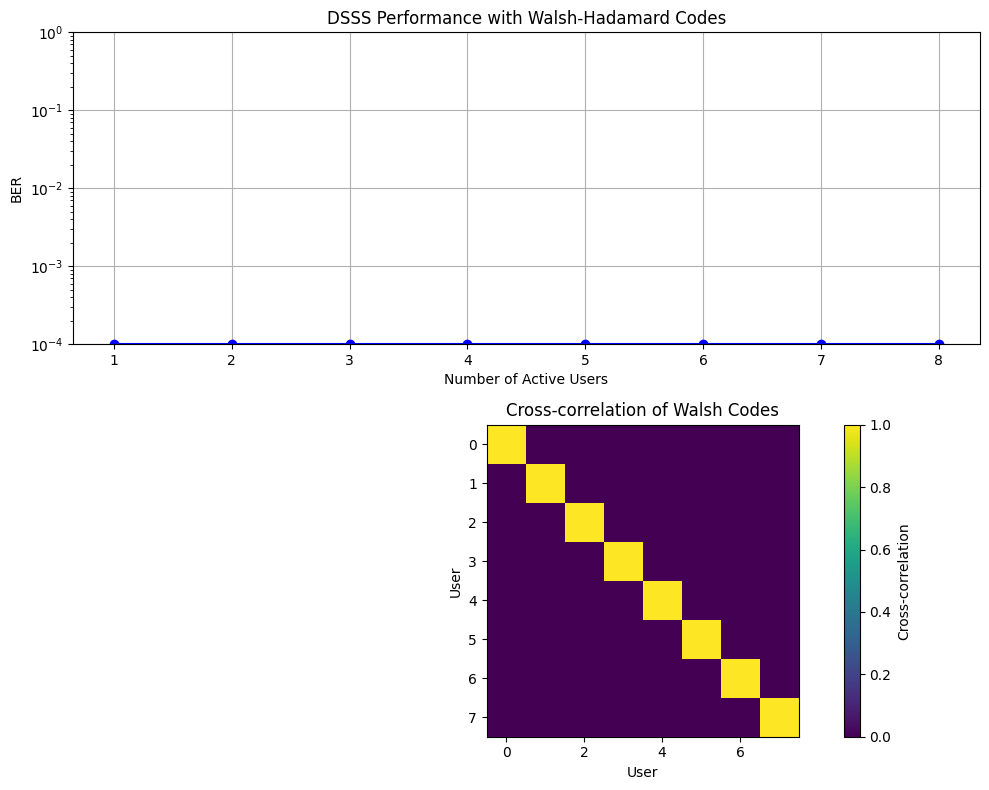

Cross-correlation matrix diagonal: [1. 1. 1. 1. 1. 1. 1. 1.]
Off-diagonal elements: 0.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def generate_walsh_codes(n):
    h1 = np.array([[1]], dtype=float)
    n = 2**int(np.ceil(np.log2(n)))
    for i in range(int(np.log2(n))):
        h1 = np.vstack((np.hstack((h1, h1)), np.hstack((h1, -h1))))
    return h1

def simulate_mai_dsss(n_users=8, n_bits=10000, noise_std=0.5):
    walsh_codes = generate_walsh_codes(n_users)
    chips_per_bit = walsh_codes.shape[1]

    ber_values = []
    user_range = range(1, n_users + 1)

    for active_users in user_range:
        errors = 0
        for _ in range(n_bits):
            user_bits = np.random.choice([1., -1.], active_users)
            received = np.zeros(chips_per_bit, dtype=float)

            # Add all users' signals
            for k in range(active_users):
                received += user_bits[k] * walsh_codes[k]

            # Add significant noise
            noise = np.random.normal(0, noise_std, chips_per_bit)
            received += noise

            # Detect first user's bit
            correlation = np.sum(received * walsh_codes[0]) / chips_per_bit
            detected = np.sign(correlation)
            if detected * user_bits[0] < 0:
                errors += 1

        ber = max(errors/n_bits, 1e-4)  # Set minimum BER for plotting
        ber_values.append(ber)

    cross_corr = np.abs(walsh_codes @ walsh_codes.T) / chips_per_bit

    plt.figure(figsize=(10, 8))

    plt.subplot(211)
    plt.semilogy(user_range, ber_values, 'bo-')
    plt.grid(True)
    plt.xlabel('Number of Active Users')
    plt.ylabel('BER')
    plt.ylim(1e-4, 1)
    plt.title('DSSS Performance with Walsh-Hadamard Codes')

    plt.subplot(212)
    plt.imshow(cross_corr, cmap='viridis')
    plt.colorbar(label='Cross-correlation')
    plt.title('Cross-correlation of Walsh Codes')
    plt.xlabel('User')
    plt.ylabel('User')

    plt.tight_layout()
    plt.show()

    print("Cross-correlation matrix diagonal:", np.diag(cross_corr))
    print("Off-diagonal elements:", np.mean(cross_corr[~np.eye(cross_corr.shape[0], dtype=bool)]))

simulate_mai_dsss()


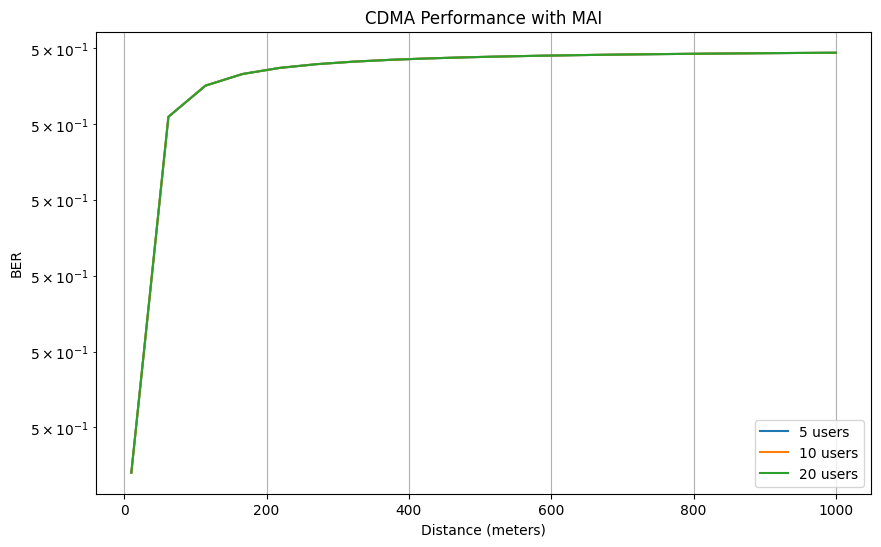

At 100m with 10 users:
BER: 5.00e-01
SINR: -151.0 dB


In [9]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt

def Q_function(x):
    return 0.5 * erfc(x/np.sqrt(2))

def calculate_ber_with_mai(users, distance_meters):
    # System parameters
    carrier_freq = 2.4e9  # 2.4 GHz
    bandwidth = 5e6       # 5 MHz
    tx_power_dBm = 23    # ~200mW mobile device
    noise_floor_dBm = -90 # Typical noise floor

    # Convert powers to linear
    tx_power = 10**(tx_power_dBm/10) / 1000  # Convert to Watts
    noise_power = 10**(noise_floor_dBm/10) / 1000

    # Path loss (simplified model)
    path_loss = 20 * np.log10(distance_meters) + 20 * np.log10(carrier_freq) - 27.55
    received_power = tx_power / (10**(path_loss/10))

    # Channel gains (Rayleigh fading)
    g = np.random.rayleigh(scale=1.0, size=users)

    # Cross-correlation values (using Walsh codes with timing errors)
    R = np.zeros((users, users))
    for i in range(users):
        for j in range(users):
            if i == j:
                R[i,j] = 1.0
            else:
                # Imperfect orthogonality due to timing errors
                R[i,j] = np.random.uniform(0, 0.1)

    # Calculate MAI for user 1
    mai_sum = 0
    for j in range(1, users):
        mai_sum += (g[j]**2 * tx_power * R[0,j]**2)

    # Calculate SINR and BER
    Eb = received_power / bandwidth  # Energy per bit
    sinr = (2 * Eb) / (Eb * mai_sum + noise_power)
    ber = Q_function(np.sqrt(sinr))

    return ber, sinr

# Analyze BER vs Distance and Number of Users
distances = np.linspace(10, 1000, 20)
user_counts = [5, 10, 20]

plt.figure(figsize=(10, 6))
for users in user_counts:
    ber_values = []
    for d in distances:
        ber, _ = calculate_ber_with_mai(users, d)
        ber_values.append(ber)
    plt.semilogy(distances, ber_values, label=f'{users} users')

plt.grid(True)
plt.xlabel('Distance (meters)')
plt.ylabel('BER')
plt.title('CDMA Performance with MAI')
plt.legend()
plt.show()

# Example calculation for a specific case
distance = 100  # meters
users = 10
ber, sinr = calculate_ber_with_mai(users, distance)
print(f"At {distance}m with {users} users:")
print(f"BER: {ber:.2e}")
print(f"SINR: {10*np.log10(sinr):.1f} dB")